## Experiment 2

In [15]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]

## 1. Apply DDPG Algorithm. Decide on the design choices in your code (e.g., network architecture) and perform hyperparameter tuning on at least two parameters of your models.

The 2 hyperparameters chosen were the tau and batch size variables as they have more defined ranges, have fewer possible values to test and each trianing run would roughly take the same time. This code was inspired by the lecturer's code of DDPG.ipynb in the MoreSOTA folder

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count
import warnings
warnings.filterwarnings("ignore")

In [3]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 100000  
MIN_REPLAY_SIZE = 10000
HIDDEN_SIZE = 128  
ACTOR_LR = 0.0003
CRITIC_LR = 0.0003

In [4]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [5]:
TAU_VALUES = [0.001, 0.005, 0.01]
BATCH_SIZES = [32, 64, 128]

In [6]:

class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [7]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class ReplayMemory():
    def __init__(self, env, capacity, batch_size):
        self.env = env
        self.memory = deque(maxlen=capacity)
        self.rewards = deque(maxlen=50)
        self.batch_size = batch_size

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batch_size)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = self.env.reset()
        for _ in range(MIN_REPLAY_SIZE):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                obs, _ = self.env.reset()
        return self

    def __len__(self):
        return len(self.memory)

In [8]:
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

In [11]:
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

In [11]:
def train_ddpg(tau, batch_size, save_model=False):
    env = gym.make('LunarLanderContinuous-v3')
    
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    output_minrange = env.action_space.low[0]
    output_maxrange = env.action_space.high[0]

    
    actor = PolicyNet(obs_size, HIDDEN_SIZE, act_size, T(output_minrange), T(output_maxrange))
    actor_target = copy.deepcopy(actor)
    critic = DQN(obs_size + act_size, HIDDEN_SIZE)
    critic_target = copy.deepcopy(critic)

    
    actor_optimizer = optim.AdamW(actor.parameters(), lr=ACTOR_LR)
    critic_optimizer = optim.AdamW(critic.parameters(), lr=CRITIC_LR)

    
    replay_memory = ReplayMemory(env, BUFFER_SIZE, batch_size).initialize()
    
    
    ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(act_size), sigma=0.2 * np.ones(act_size))

    def update():
        if len(replay_memory) < batch_size:
            return
            
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()

        ou_noise.reset()
        
        Qvals = critic(states, actions)
        with torch.no_grad():
            actions_ = actor_target(next_states)
            Qvals_ = critic_target(next_states, actions_)
            Qvals_[dones] = 0.0
            target = rewards + GAMMA * Qvals_
        critic_loss = F.smooth_l1_loss(target, Qvals)

        
        actor_loss = -critic(states, actor(states)).mean()

        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        
        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
            target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

    
    returns = deque(maxlen=50)
    all_returns = []

    for episode in count():
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                action = actor(T(state)).numpy() + ou_noise()
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            transition = Transition(state, action, reward, done, new_state)
            replay_memory.append(transition)
            update()
            state = new_state
            episode_reward += reward

        returns.append(episode_reward)
        all_returns.append(episode_reward)
        avg_return = np.mean(returns)

        if episode > 0 and episode % 50 == 0:
            print(f'Episode: {episode}  Return: {episode_reward:.2f}  Average Return: {avg_return:.2f}')

        
        if len(returns) >= 50 and avg_return >= 195:
            print(f'Solved in {episode} episodes! Average Return: {avg_return:.2f}')
            break

        if episode >= 2000:
            print(f'Reached maximum episodes (2000) without solving. Final Average Return: {avg_return:.2f}')
            break

    
    if save_model:
        torch.save({
            'actor_state_dict': actor.state_dict(),
            'critic_state_dict': critic.state_dict(),
            'config': {
                'tau': tau,
                'batch_size': batch_size,
                'hidden_size': HIDDEN_SIZE,
                'actor_lr': ACTOR_LR,
                'critic_lr': CRITIC_LR
            }
        }, 'best_ddpg_model.pt')

    env.close()
    return all_returns, episode, avg_return

Starting hyperparameter tuning...

Testing tau=0.001, batch_size=32
Episode: 50  Return: 20.82  Average Return: -128.72
Episode: 100  Return: -78.44  Average Return: -102.68
Episode: 150  Return: -19.49  Average Return: -26.06
Episode: 200  Return: -24.61  Average Return: -7.12
Episode: 250  Return: -99.91  Average Return: -9.36
Episode: 300  Return: 113.12  Average Return: 166.24
Solved in 318 episodes! Average Return: 196.46

Current best configuration:
Tau: 0.001, Batch Size: 32
Episodes to solve: 318
Average return: 196.46

Testing tau=0.001, batch_size=64
Episode: 50  Return: 228.41  Average Return: -6.41
Episode: 100  Return: -22.80  Average Return: 89.22
Episode: 150  Return: -26.75  Average Return: 42.28
Episode: 200  Return: -0.11  Average Return: 96.37
Episode: 250  Return: 216.27  Average Return: 106.31
Solved in 292 episodes! Average Return: 195.24

Current best configuration:
Tau: 0.001, Batch Size: 64
Episodes to solve: 292
Average return: 195.24

Testing tau=0.001, batch

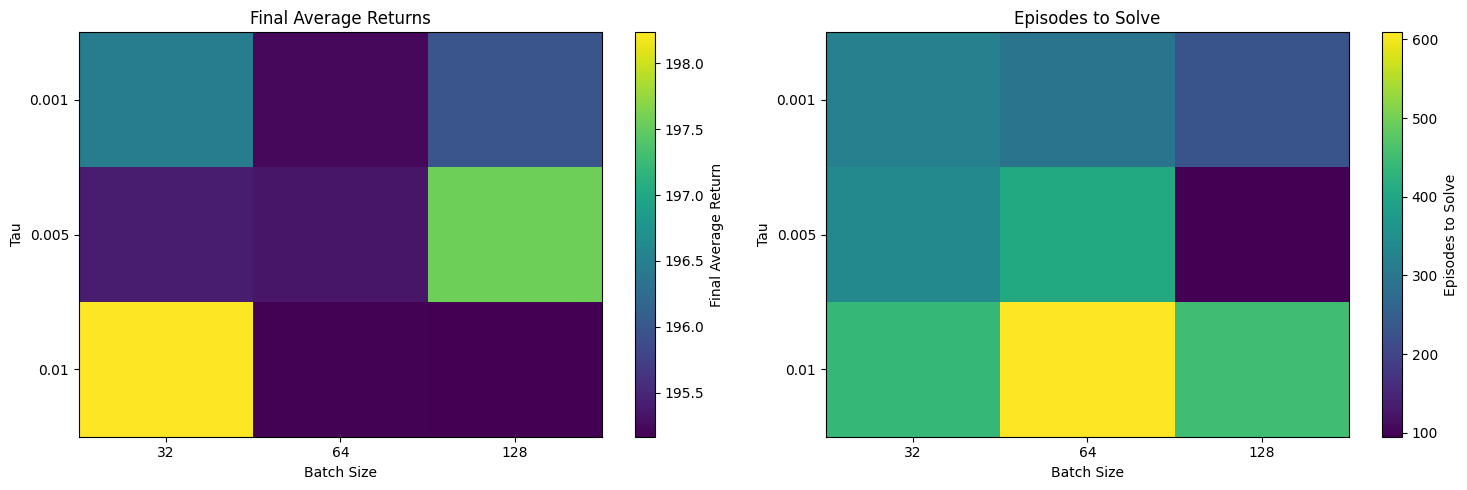


Best Configuration (Fastest to Solve):
Configuration: tau_0.005_batch_128
Tau: 0.005
Batch Size: 128
Episodes to solve: 95
Final Average Return: 197.56


In [10]:
def find_best_hyperparameters():
    results = {}
    best_episodes = float('inf')  
    best_tau = None
    best_batch = None
    
    
    for tau in TAU_VALUES:
        for batch_size in BATCH_SIZES:
            print(f"\nTesting tau={tau}, batch_size={batch_size}")
            
            
            returns, episodes, final_avg = train_ddpg(tau, batch_size, save_model=False)
            
            
            config_name = f"tau_{tau}_batch_{batch_size}"
            results[config_name] = {
                'returns': returns,
                'episodes': episodes,
                'final_avg': final_avg,
                'config': {'tau': tau, 'batch_size': batch_size}
            }
            
            
            if episodes < best_episodes:
                best_episodes = episodes
                best_tau = tau
                best_batch = batch_size
                
            print(f"\nCurrent best configuration:")
            print(f"Tau: {best_tau}, Batch Size: {best_batch}")
            print(f"Episodes to solve: {best_episodes}")
            print(f"Average return: {final_avg:.2f}")
    
    
    print("\nTraining final model with best parameters...")
    train_ddpg(best_tau, best_batch, save_model=True)
    
    return results



print("Starting hyperparameter tuning...")
results = find_best_hyperparameters()


tau_labels = [str(tau) for tau in TAU_VALUES]
batch_labels = [str(bs) for bs in BATCH_SIZES]
final_returns = np.zeros((len(TAU_VALUES), len(BATCH_SIZES)))
episodes_to_solve = np.zeros((len(TAU_VALUES), len(BATCH_SIZES)))

for i, tau in enumerate(TAU_VALUES):
    for j, batch_size in enumerate(BATCH_SIZES):
        config_name = f"tau_{tau}_batch_{batch_size}"
        final_returns[i, j] = results[config_name]['final_avg']
        episodes_to_solve[i, j] = results[config_name]['episodes']


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(final_returns, cmap='viridis', aspect='auto')
plt.colorbar(label='Final Average Return')
plt.xticks(range(len(batch_labels)), batch_labels)
plt.yticks(range(len(tau_labels)), tau_labels)
plt.xlabel('Batch Size')
plt.ylabel('Tau')
plt.title('Final Average Returns')

plt.subplot(1, 2, 2)
plt.imshow(episodes_to_solve, cmap='viridis', aspect='auto')
plt.colorbar(label='Episodes to Solve')
plt.xticks(range(len(batch_labels)), batch_labels)
plt.yticks(range(len(tau_labels)), tau_labels)
plt.xlabel('Batch Size')
plt.ylabel('Tau')
plt.title('Episodes to Solve')

plt.tight_layout()
plt.show()


best_config = min(results.items(), key=lambda x: x[1]['episodes'])  
print("\nBest Configuration (Fastest to Solve):")
print(f"Configuration: {best_config[0]}")
print(f"Tau: {best_config[1]['config']['tau']}")
print(f"Batch Size: {best_config[1]['config']['batch_size']}")
print(f"Episodes to solve: {best_config[1]['episodes']}")
print(f"Final Average Return: {best_config[1]['final_avg']:.2f}")

In [ ]:

import torch

#to check the model has been saved
checkpoint = torch.load('best_ddpg_model.pt')


print("\nSaved Model Parameters:")
print("-" * 30)
for key, value in checkpoint['config'].items():
    print(f"{key}: {value}")


print("\nVerifying Critical Parameters:")
print("-" * 30)
print(f"Tau is 0.005: {checkpoint['config']['tau'] == 0.005}")
print(f"Batch Size is 128: {checkpoint['config']['batch_size'] == 128}")


print("\nVerifying Model Components:")
print("-" * 30)
print(f"Actor state dict present: {'actor_state_dict' in checkpoint}")
print(f"Critic state dict present: {'critic_state_dict' in checkpoint}")


Saved Model Parameters:
------------------------------
tau: 0.005
batch_size: 128
hidden_size: 128
actor_lr: 0.0003
critic_lr: 0.0003

Verifying Critical Parameters:
------------------------------
Tau is 0.005: True
Batch Size is 128: True

Verifying Model Components:
------------------------------
Actor state dict present: True
Critic state dict present: True


## 2. Noise plays a critical role in DDPG by promoting exploration. You are asked to test and analyse the impact of various noise settings (HIGH-MEDIUM-LOW) on the DDPG algorithm for this specific environment.


Testing HIGH noise level (sigma=0.3)...
Episode: 10  Return: 243.20  Average Return: 135.61
Episode: 20  Return: 21.08  Average Return: 174.28
Episode: 30  Return: 286.13  Average Return: 168.12
Episode: 40  Return: 245.06  Average Return: 173.92
Episode: 50  Return: -324.75  Average Return: 156.77
Episode: 60  Return: 253.69  Average Return: 178.22
Episode: 70  Return: 34.47  Average Return: 184.18
Solved in 76 episodes! Average Return: 198.38

Testing MEDIUM noise level (sigma=0.2)...
Episode: 10  Return: 240.52  Average Return: 190.41
Episode: 20  Return: 253.68  Average Return: 183.17
Episode: 30  Return: 286.98  Average Return: 201.79
Episode: 40  Return: 263.32  Average Return: 186.65
Episode: 50  Return: 263.21  Average Return: 183.04
Episode: 60  Return: 34.97  Average Return: 178.19
Episode: 70  Return: 285.02  Average Return: 185.28
Episode: 80  Return: 273.62  Average Return: 166.68
Episode: 90  Return: 282.73  Average Return: 178.42
Solved in 98 episodes! Average Return: 1

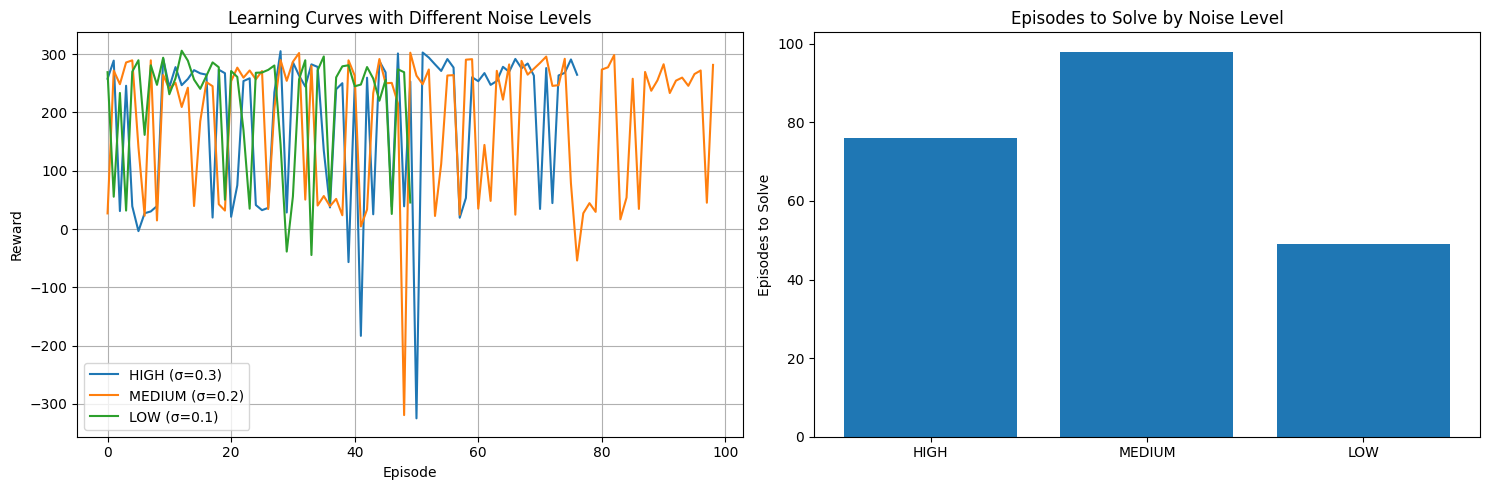


Detailed Results:
--------------------------------------------------

HIGH Noise Results (σ=0.3):
Solved at: 76
Final Average Return: 198.38 ± 131.20

MEDIUM Noise Results (σ=0.2):
Solved at: 98
Final Average Return: 196.38 ± 118.89

LOW Noise Results (σ=0.1):
Solved at: 49
Final Average Return: 212.81 ± 99.26


In [14]:

checkpoint = torch.load('best_ddpg_model.pt')
CONFIG = checkpoint['config']


NOISE_LEVELS = {
    'HIGH': {'sigma': 0.3, 'theta': 0.15},    
    'MEDIUM': {'sigma': 0.2, 'theta': 0.15},  
    'LOW': {'sigma': 0.1, 'theta': 0.15}      
}


def test_noise_level(noise_config, max_episodes=2000):
    """Test a specific noise configuration"""
    env = gym.make('LunarLanderContinuous-v3')
    
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    output_minrange = env.action_space.low[0]
    output_maxrange = env.action_space.high[0]

    
    actor = PolicyNet(obs_size, CONFIG['hidden_size'], act_size, 
                     T(output_minrange), T(output_maxrange))
    critic = DQN(obs_size + act_size, CONFIG['hidden_size'])
    
    actor.load_state_dict(checkpoint['actor_state_dict'])
    critic.load_state_dict(checkpoint['critic_state_dict'])
    
    
    ou_noise = OrnsteinUhlenbeckActionNoise(
        mu=np.zeros(act_size),
        sigma=noise_config['sigma'] * np.ones(act_size),
        theta=noise_config['theta']
    )

    episode_rewards = []
    returns = deque(maxlen=50)  
    solved_at = None
    
    for episode in count():
        state, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            with torch.no_grad():
                
                action = actor(T(state)).numpy()
                noisy_action = action + ou_noise()
                
                
                next_state, reward, terminated, truncated, _ = env.step(noisy_action)
                done = terminated or truncated
                
                state = next_state
                episode_reward += reward
        
        returns.append(episode_reward)
        episode_rewards.append(episode_reward)
        avg_return = np.mean(returns)

        if episode > 0 and episode % 10 == 0:
            print(f'Episode: {episode}  Return: {episode_reward:.2f}  Average Return: {avg_return:.2f}')

        
        if len(returns) >= 50 and avg_return >= 195:
            print(f'Solved in {episode} episodes! Average Return: {avg_return:.2f}')
            solved_at = episode
            break

        if episode >= max_episodes:
            print(f'Reached maximum episodes ({max_episodes}) without solving. Final Average Return: {avg_return:.2f}')
            break
            
        
        ou_noise.reset()

    env.close()
    return episode_rewards, solved_at, avg_return



results = {}
for level, config in NOISE_LEVELS.items():
    print(f"\nTesting {level} noise level (sigma={config['sigma']})...")
    rewards, solved_episode, final_avg = test_noise_level(config)
    results[level] = {
        'rewards': rewards,
        'solved_at': solved_episode if solved_episode is not None else 'Not solved',
        'final_avg': final_avg,
        'std_reward': np.std(rewards)
    }



plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
for level in NOISE_LEVELS.keys():
    rewards = results[level]['rewards']
    plt.plot(rewards, label=f'{level} (σ={NOISE_LEVELS[level]["sigma"]})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Learning Curves with Different Noise Levels')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
levels = list(NOISE_LEVELS.keys())
episodes_to_solve = []
for level in levels:
    if isinstance(results[level]['solved_at'], int):
        episodes_to_solve.append(results[level]['solved_at'])
    else:
        episodes_to_solve.append(2000)  
plt.bar(levels, episodes_to_solve)
plt.title('Episodes to Solve by Noise Level')
plt.ylabel('Episodes to Solve')

plt.tight_layout()
plt.show()


print("\nDetailed Results:")
print("-" * 50)
for level in NOISE_LEVELS.keys():
    print(f"\n{level} Noise Results (σ={NOISE_LEVELS[level]['sigma']}):")
    print(f"Solved at: {results[level]['solved_at']}")
    print(f"Final Average Return: {results[level]['final_avg']:.2f} ± {results[level]['std_reward']:.2f}")

Key Observations:

Performance Degradation with Noise:

As noise increases, the average return slightly decreases from 212.81 (LOW) → 196.38 (MEDIUM) → 198.38 (HIGH).
However, DDPG maintains high performance even under high noise, showing strong robustness.
Convergence Speed (Solved at Timesteps):

LOW noise: Fastest convergence at 49 timesteps.

MEDIUM noise: Takes nearly double the time (98 timesteps), indicating more instability.

HIGH noise: Faster convergence (76 timesteps) than at medium noise, suggesting some adaptation.

Variance increases with noise, meaning performance fluctuates more as the environment becomes more uncertain.
Despite high variance at σ=0.3, the model maintains strong returns, indicating DDPG can adapt to stochastic conditions.

DDPG is highly resistant to noise, maintaining strong performance across all levels.
Performance drops slightly, but remains high even at σ=0.3, proving adaptability.
Variance increases with noise, making the model slightly less stable, but it still converges reliably.
Slower learning at medium noise (98 timesteps), but faster adaptation at high noise (76 timesteps).
